## Lab: RNN with Forecasting

### Wind Turbine Power Prediction with RNN

This lab uses a Recurrent Neural Network to predict wind turbine power output.
* [Data link](https://www.kaggle.com/code/ahmedfathygwely/wind-turbine-dataset-machine-learning-rnn-times/input)

### Step 0: Load libraries & Data

In [3]:
# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the data
df = pd.read_csv('T1.csv')

In [4]:
# Display basic information
print(df.shape)
print(df.head())

(50530, 5)
          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  


### Step 1: Prepare the data

In [5]:
# Step 1: Prepare the data
# convert date/time column to datetime object
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')

# check date/time column format
print(df.head())

            Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:00:00           380.047791          5.311336   
1 2018-01-01 00:10:00           453.769196          5.672167   
2 2018-01-01 00:20:00           306.376587          5.216037   
3 2018-01-01 00:30:00           419.645905          5.659674   
4 2018-01-01 00:40:00           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  


In [6]:
# check for nulls
print(df.isnull().sum())

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64


In [7]:
# get summary statistics
print(df.describe())

                           Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
count                          50530         50530.000000      50530.000000   
mean   2018-07-01 20:01:30.065307648          1307.684332          7.557952   
min              2018-01-01 00:00:00            -2.471405          0.000000   
25%              2018-04-03 05:22:30            50.677890          4.201395   
50%              2018-06-30 16:15:00           825.838074          7.104594   
75%              2018-09-26 18:57:30          2482.507568         10.300020   
max              2018-12-31 23:50:00          3618.732910         25.206011   
std                              NaN          1312.459242          4.227166   

       Theoretical_Power_Curve (KWh)  Wind Direction (°)  
count                   50530.000000        50530.000000  
mean                     1492.175463          123.687559  
min                         0.000000            0.000000  
25%                       161.328167           49.31

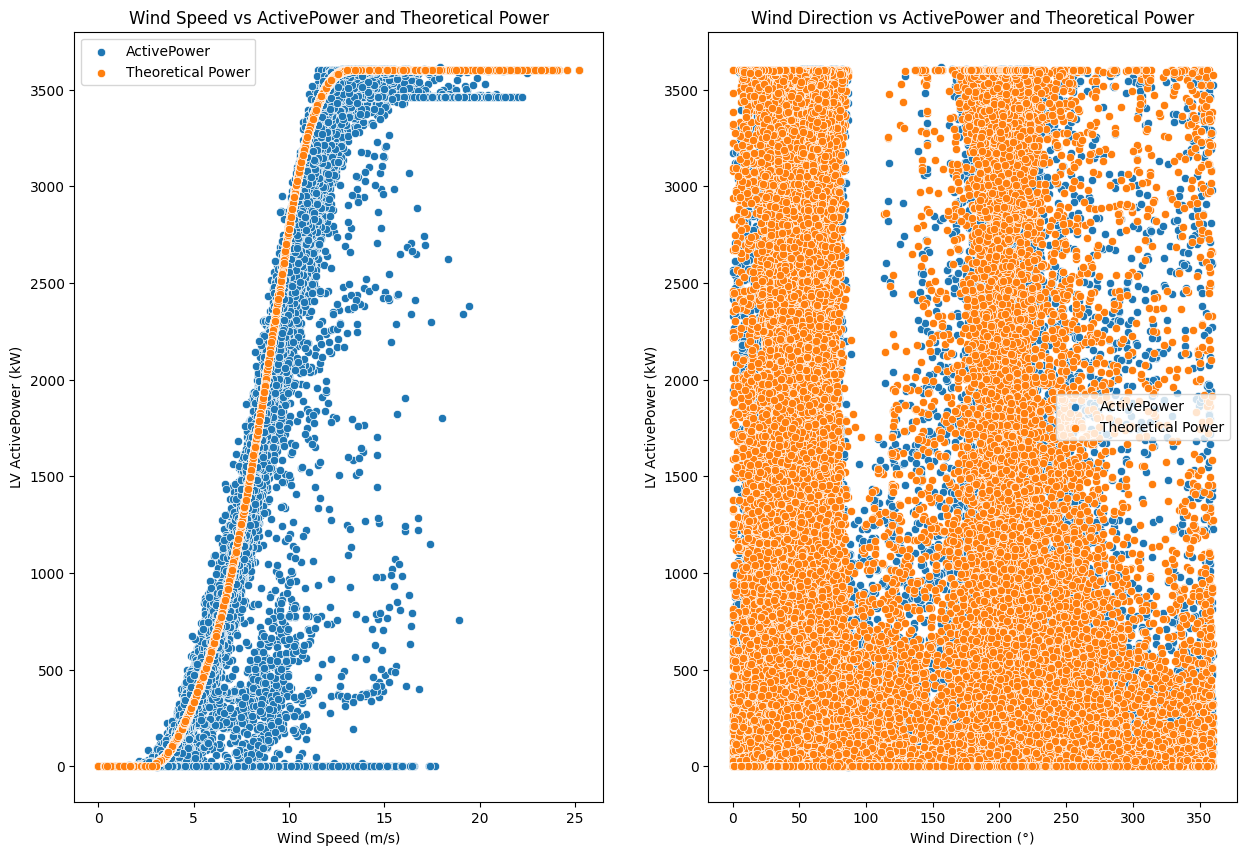

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

sns.scatterplot(data=df, x='Wind Speed (m/s)', y='LV ActivePower (kW)', label='ActivePower', ax=axes[0])
sns.scatterplot(data=df, x='Wind Speed (m/s)', y='Theoretical_Power_Curve (KWh)', label='Theoretical Power', ax=axes[0])
axes[0].set_title('Wind Speed vs ActivePower and Theoretical Power')

sns.scatterplot(data=df, x='Wind Direction (°)', y='LV ActivePower (kW)', label='ActivePower', ax=axes[1])
sns.scatterplot(data=df, x='Wind Direction (°)', y='Theoretical_Power_Curve (KWh)', label='Theoretical Power', ax=axes[1])
axes[1].set_title('Wind Direction vs ActivePower and Theoretical Power')

axes[0].legend()
axes[1].legend()
plt.show()

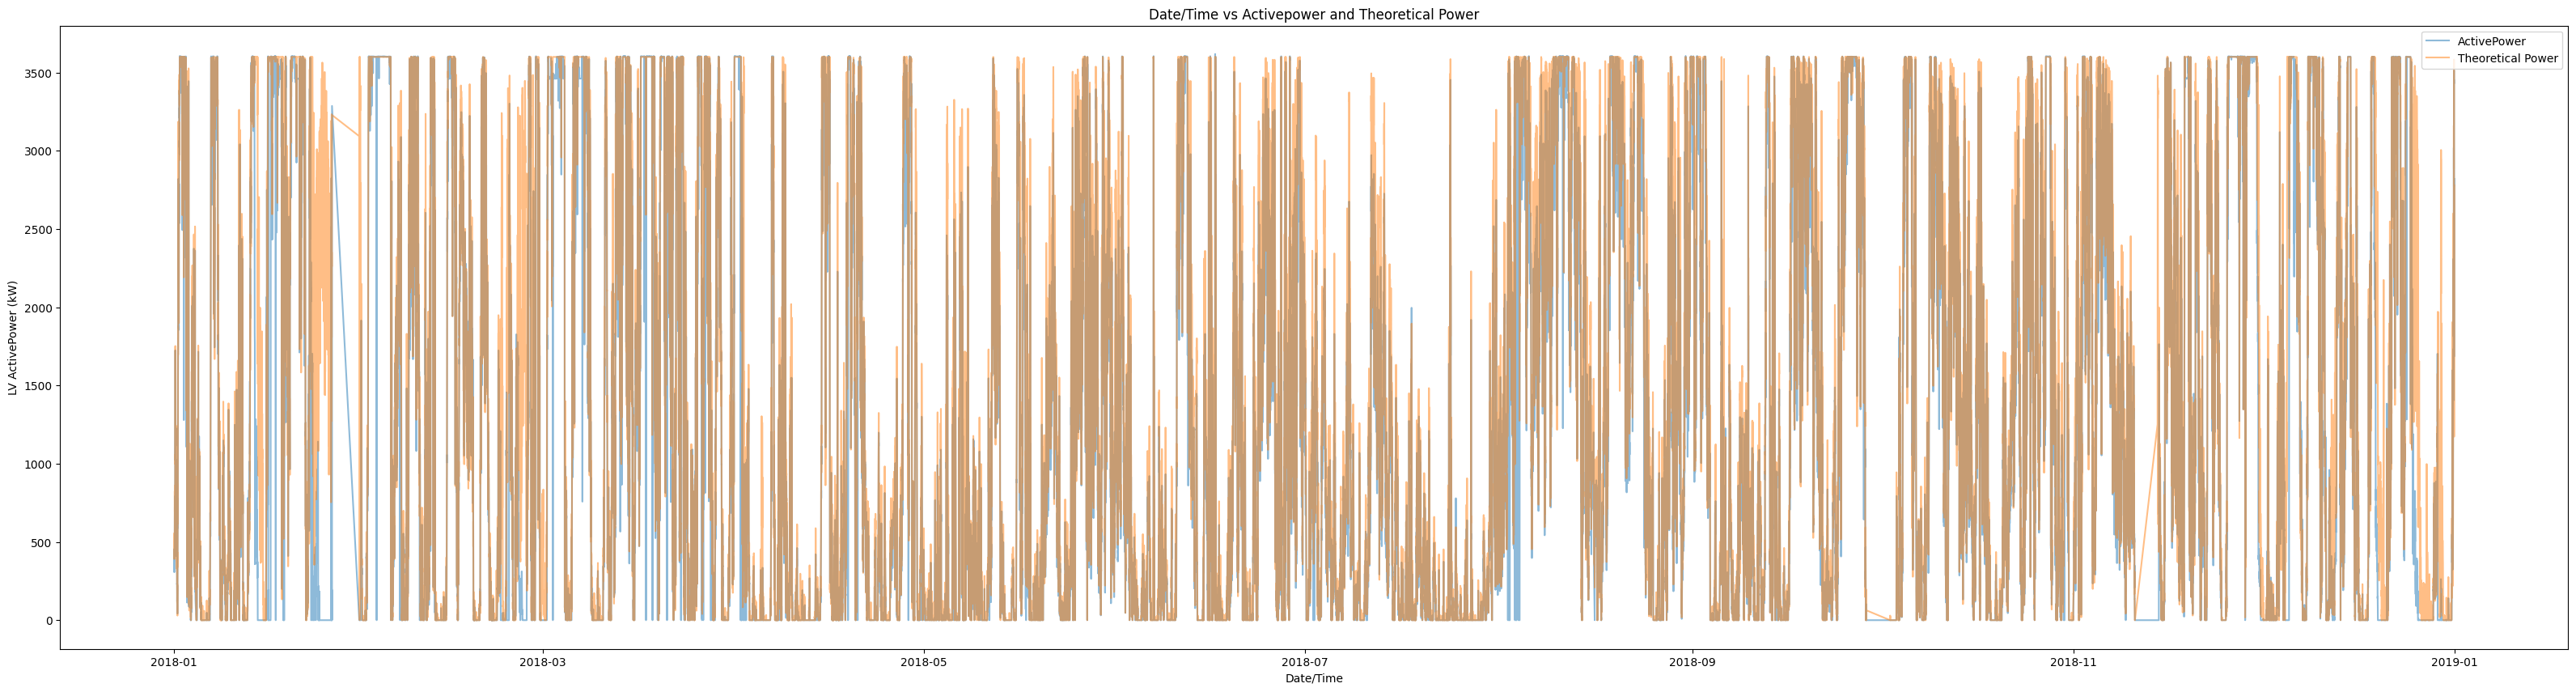

In [9]:
plt.figure(figsize=(40, 10))
sns.lineplot(data=df, x='Date/Time', y='LV ActivePower (kW)', label='ActivePower', alpha=0.5)
sns.lineplot(data=df, x='Date/Time', y='Theoretical_Power_Curve (KWh)', label='Theoretical Power', alpha=0.5)
plt.title('Date/Time vs Activepower and Theoretical Power')
plt.show()

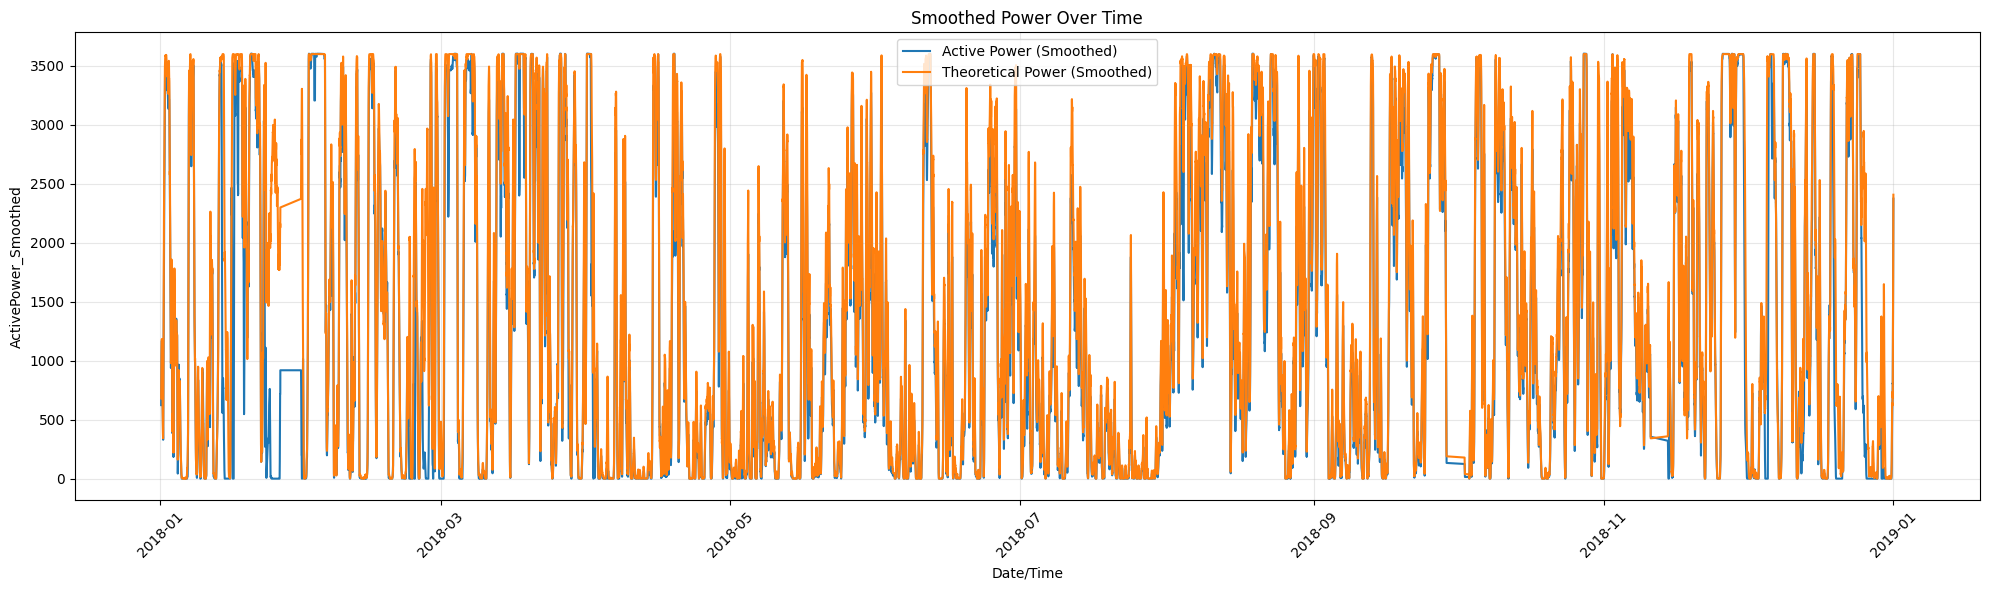

In [10]:
df_resampled = df.resample('D', on='Date/Time').mean()
df['ActivePower_Smoothed'] = df['LV ActivePower (kW)'].rolling(window=24).mean()
df['Theoretical_Smoothed'] = df['Theoretical_Power_Curve (KWh)'].rolling(window=24).mean()
plt.figure(figsize=(20, 6))
sns.lineplot(data=df, x='Date/Time', y='ActivePower_Smoothed', label='Active Power (Smoothed)')
sns.lineplot(data=df, x='Date/Time', y='Theoretical_Smoothed', label='Theoretical Power (Smoothed)')
plt.title('Smoothed Power Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
# create new df with relevant columns
df_select = df[['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)']]
print(df_select)

       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)
0               380.047791          5.311336                     416.328908
1               453.769196          5.672167                     519.917511
2               306.376587          5.216037                     390.900016
3               419.645905          5.659674                     516.127569
4               380.650696          5.577941                     491.702972
...                    ...               ...                            ...
50525          2963.980957         11.404030                    3397.190793
50526          1684.353027          7.332648                    1173.055771
50527          2201.106934          8.435358                    1788.284755
50528          2515.694092          9.421366                    2418.382503
50529          2820.466064          9.979332                    2779.184096

[50530 rows x 3 columns]


In [20]:
# normalize columns in new df
from sklearn.preprocessing import MinMaxScaler

# Features and target
features = ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)']
target = ['LV ActivePower (kW)']

# Fit scalers separately
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[target])

# Combine for sequence creation
scaled_data = np.hstack([y_scaled, X_scaled])  # target first, then features


print(scaled_data)

[[0.10563314 0.21071704 0.11564692]
 [0.1259914  0.22503231 0.14442153]
 [0.08528875 0.20693623 0.10858334]
 ...
 [0.60852085 0.33465661 0.49674577]
 [0.69539448 0.37377457 0.67177292]
 [0.77955763 0.3959108  0.77199558]]


### Step 2: Create sequences

In [21]:
# Step 2: Create sequences

def create_sequences(dataset, seq_length):
  X = []
  y = []
  for i in range(len(dataset) - seq_length):
    X.append(dataset[i: i+seq_length])
    y.append(dataset[i+seq_length])

  X = np.array(X)
  y = np.array(y)

  print(X.shape, y.shape)
  return X, y

seq_length = 24

X, y = create_sequences(scaled_data, seq_length)

# Only keep the target column (first column) from y
y = y[:, 0].reshape(-1, 1)

(50506, 24, 3) (50506, 3)


### Step 3: Split the data

In [22]:
# Step 3: Split the data
train_size = int(len(X) * 0.8)

# split into train and test sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# check sizes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40404, 24, 3) (10102, 24, 3) (40404, 1) (10102, 1)


### Step 4: Build the RNN Model

In [23]:
# Step 4: Build the RNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

model = Sequential()
# lstm with 50 neurons, tanh squashes values to between -1 and 1 to maintain
# stable gradients during backpropagation
model.add(LSTM(50, activation='tanh', input_shape=(seq_length, 3)))

model.add(Dropout(0.3))
# add a fully connected (dense) output layer with 1 unit for regression,
# predicting a single numeric value (power output)
model.add(Dense(1))
# adam adjusts learning rate for each parameter individually
# mse used for regression tasks, where predicting continuous n umeric values
model.compile(optimizer='adam', loss='mse')

# telling Keras, train this model using adam optimizer and minimize the mse between
# predictions and truth

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,851 (42.39 KB)

 Trainable params: 10,851 (42.39 KB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Train the model

In [24]:
# Step 5: Train the model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False  # use shuffle=False for time series
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,               # number of epochs with no improvement before stopping
    restore_best_weights=True  # restores model weights from the best epoch
)

history = model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[early_stop], \
                    validation_data = (X_val, y_val), verbose=1)

Epoch 1/100
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0203 - val_loss: 0.0044
Epoch 2/100
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0075 - val_loss: 0.0042
Epoch 3/100
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 4/100
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0064 - val_loss: 0.0044
Epoch 5/100
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0063 - val_loss: 0.0044
Epoch 6/100
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0062 - val_loss: 0.0045
Epoch 7/100
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0061 - val_loss: 0.0046


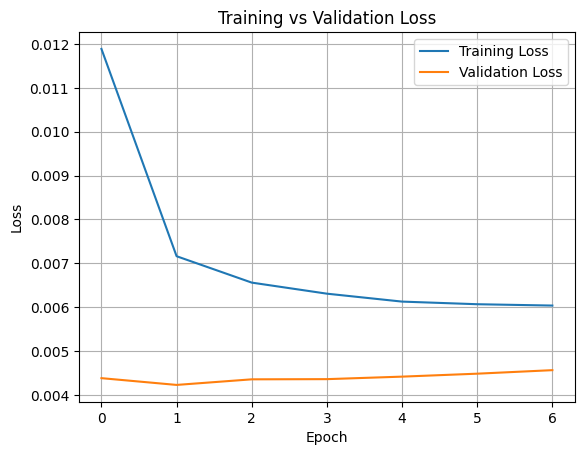

In [25]:
# plot training history, loss vs val_loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Step 6: Evaluate on the test data and visualize the results

In [29]:
# Step 6: Evaluate and visualize

y_pred = model.predict(X_test)

y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

from sklearn.metrics import mean_squared_error, r2_score
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"r2: {r2}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MSE: 54522.006083470114
RMSE: 233.49947769421266
r2: 0.9697259426051343


Mean squared error of ~54k penalizes large errors heavily.
RMSE of 233.5 means predictions are off by 233kW.
R2 score of 0.9697 explains ~97% of the variance, as the model is a strong fit and generalizes well on unseen data.

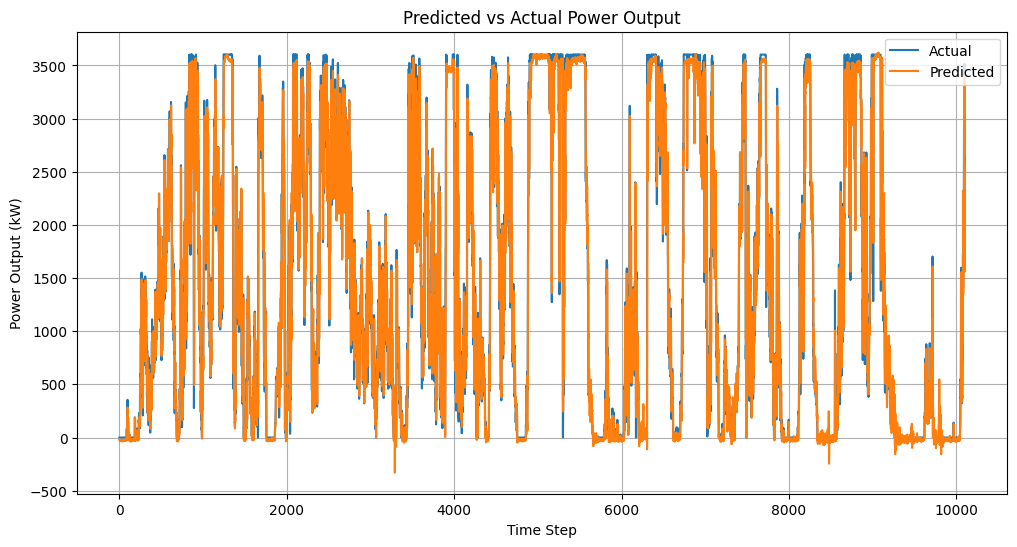

In [30]:
# time series plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Predicted vs Actual Power Output')
plt.xlabel('Time Step')
plt.ylabel('Power Output (kW)')
plt.legend()
plt.grid(True)
plt.show()

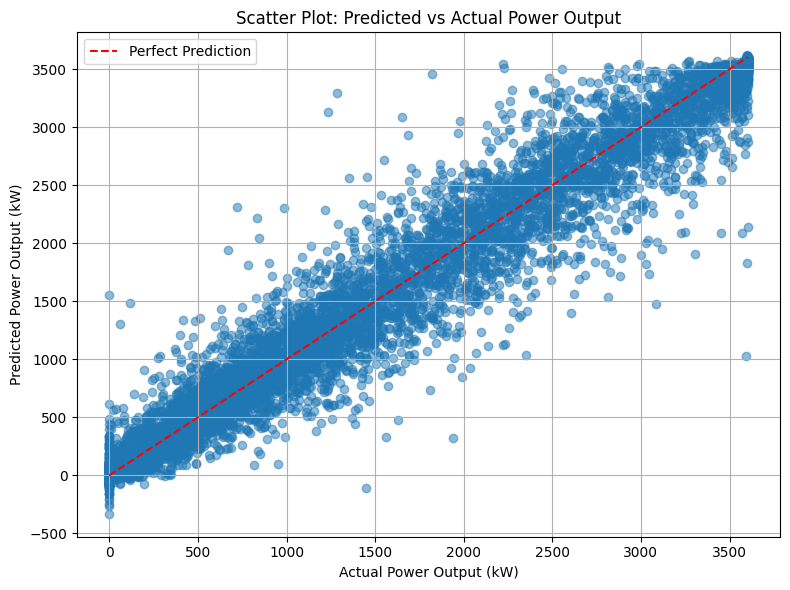

In [32]:
# scatter plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()],
         [y_test_inv.min(), y_test_inv.max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Power Output (kW)')
plt.ylabel('Predicted Power Output (kW)')
plt.title('Scatter Plot: Predicted vs Actual Power Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

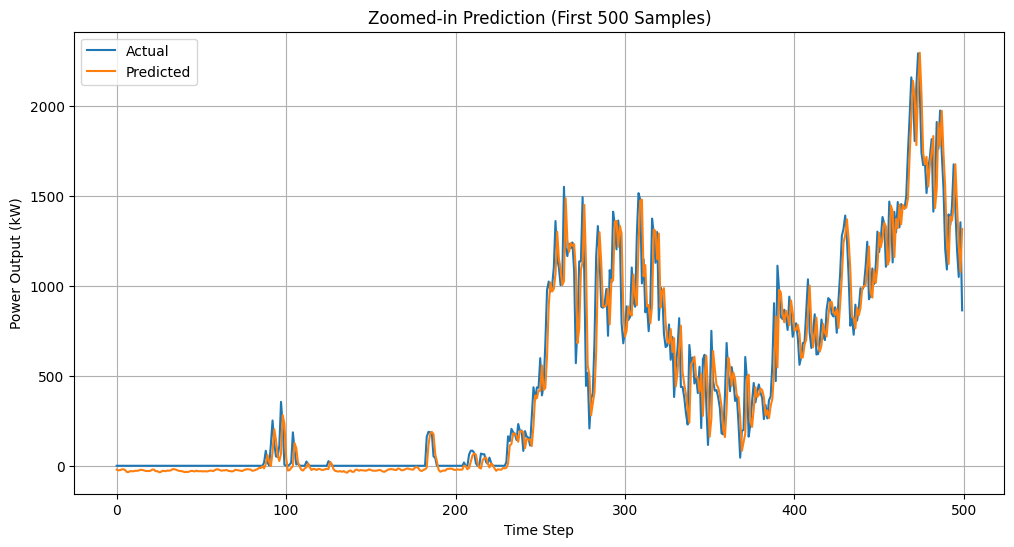

In [34]:
# zoom in on first 500 points

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:500], label='Actual')
plt.plot(y_pred_inv[:500], label='Predicted')
plt.title('Zoomed-in Prediction (First 500 Samples)')
plt.xlabel('Time Step')
plt.ylabel('Power Output (kW)')
plt.legend()
plt.grid(True)
plt.show()

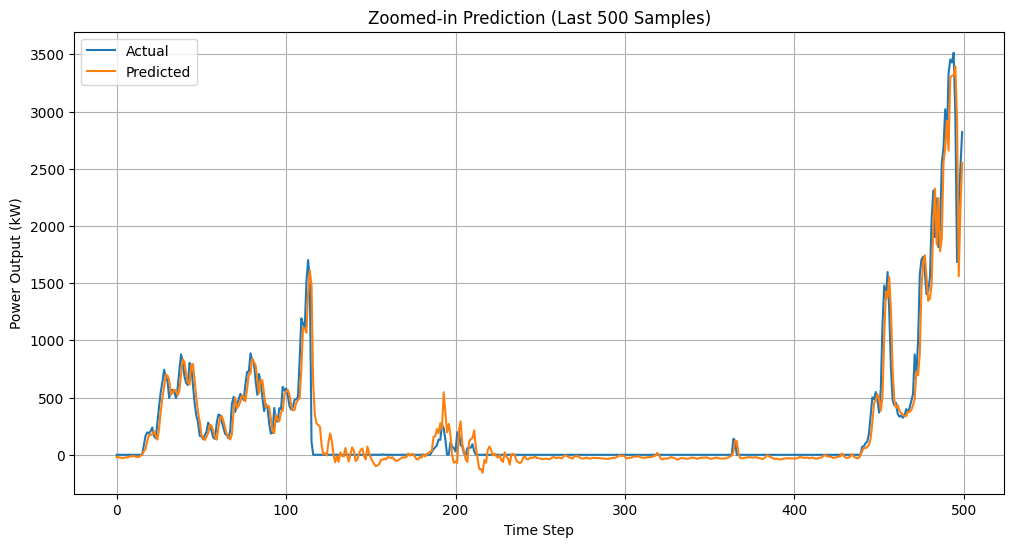

In [36]:
# zoom in on last 500

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[-500:], label='Actual')
plt.plot(y_pred_inv[-500:], label='Predicted')
plt.title('Zoomed-in Prediction (Last 500 Samples)')
plt.xlabel('Time Step')
plt.ylabel('Power Output (kW)')
plt.legend()
plt.grid(True)
plt.show()